##Applying RNN to Time Series Data

***Preparing the Data***

In [ ]:
import zipfile
#Downloading the dataset

!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-09 00:45:23--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.136.16, 52.217.126.40, 54.231.132.64, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.136.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  14.8MB/s    in 0.9s    

2024-04-09 00:45:25 (14.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


*Inspecting the data of the Jena weather forecast*

In [ ]:
#Defining the file path
import os
forecast_data = os.path.join("jena_climate_2009_2016.csv")

with open(forecast_data) as f:
  data = f.read()

lines = data.split("\n")         #Splitting the data into lines
header = lines[0].split(",")     #Extracting header
lines = lines[1:]                #Remove header from lines

#Printing the column names
print("Column Names: ", header, "\n")

#Printing the number of lines in the data
print("Number of lines in the data: ", len(lines))


Column Names:  ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"'] 

Number of lines in the data:  420451


*Analysing the data*

In [ ]:
import numpy as np

#Initialize arrays to store temperature and raw data
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Text(0, 0.5, 'Temperature')

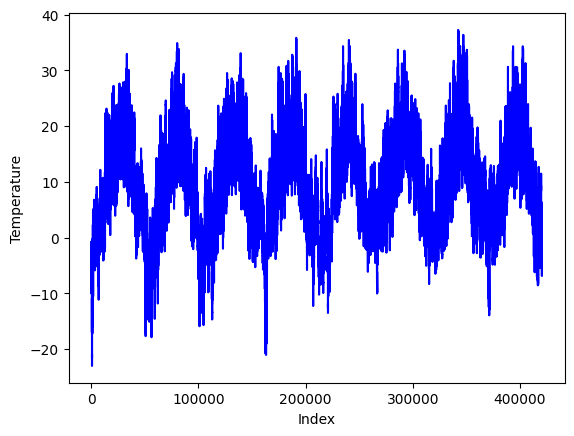

In [ ]:
#Plotting the temperature time series

from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature, color = "blue")

plt.xlabel('Index')  # Label for x-axis
plt.ylabel('Temperature')  # Label for y-axis


Text(0, 0.5, 'Temperature')

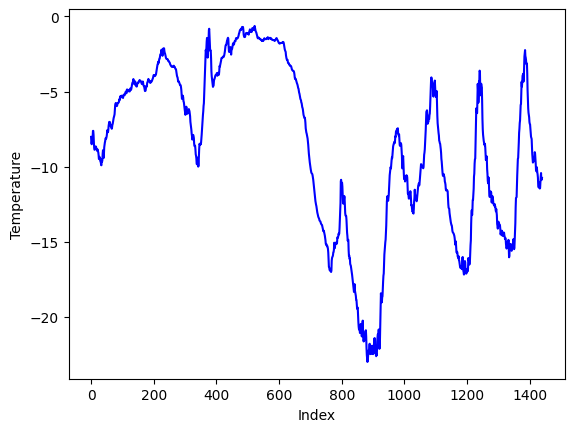

In [ ]:
#Plotting the first 10 days of temperature time series

plt.plot(range(1440), temperature[:1440], color = "blue")

plt.xlabel('Index')  # Label for x-axis
plt.ylabel('Temperature')  # Label for y-axis

In [ ]:
#Compute the number of samples we will use for each data split - 50% for training and 20% for validation

#Training samples - 50%
num_train_samples = int(0.5 * len(raw_data))

#Validation samples - 25%
num_val_samples = int(0.25 * len(raw_data))

#Test samples - remaining samples (25%)
num_test_samples = len(raw_data) - num_train_samples - num_val_samples


print("No. of training samples:", num_train_samples)
print("No. of validation samples:", num_val_samples)
print("No. of test samples:", num_test_samples)

No. of training samples: 210225
No. of validation samples: 105112
No. of test samples: 105114


In [ ]:
#Normalizing the data

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
#Understanding time series data from the array

import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
data=int_sequence[:-3],
targets=int_sequence[3:],
sequence_length=3,
batch_size=2,
)

for inputs, targets in dummy_dataset:
  for i in range(inputs.shape[0]):
    print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [ ]:
#Instantiating the datasets for training, validation and testing

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
#Inspecting the output of one of our datasets

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


*Computing the common-sense baseline MAE*

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}", "Degree celsius")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}", "Degree celsius")

Validation MAE: 2.44 Degree celsius
Test MAE: 2.62 Degree celsius


Here we have used common-sense baseline approach. So, predicting the temperature in next 24 hours will be same as the current temperature. Here, the Test MAE (Mean absolute error) is 2.62 degree celsius, whereas the validation MAE is 2.44 degree celsius. In other words, assuming that the temperature in the future remains the same as the current temperature would result in an average deviation of approximately two and a half degrees.

*A basic Machine learning model - Dense Layer*

In [ ]:
#Training and evaluating a densely connected model

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 14s 15ms/step - loss: 13.5078 - mae: 2.8296 - val_loss: 12.2843 - val_mae: 2.7847
Epoch 2/10
819/819 [==============================] - 12s 15ms/step - loss: 9.1923 - mae: 2.3842 - val_loss: 10.2677 - val_mae: 2.5335
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 8.4910 - mae: 2.2913 - val_loss: 10.2383 - val_mae: 2.5401
Epoch 4/10
819/819 [==============================] - 12s 15ms/step - loss: 8.0272 - mae: 2.2257 - val_loss: 10.3646 - val_mae: 2.5562
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 7.7104 - mae: 2.1816 - val_loss: 11.1463 - val_mae: 2.6465
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 7.4422 - mae: 2.1436 - val_loss: 10.8991 - val_mae: 2.6244
Epoch 7/10
819/819 [==============================] - 13s 15ms/step - loss: 7.2334 - mae: 2.1127 - val_loss: 11.0496 - val_mae: 2.6416
Epoch 8/10
819/819 [==============================] - 

In [ ]:
#Reloading the best model and evaluating it on the test data

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}", "Degree celsius")

405/405 [==============================] - 5s 11ms/step - loss: 11.7017 - mae: 2.6928
Test MAE: 2.69 Degree celsius


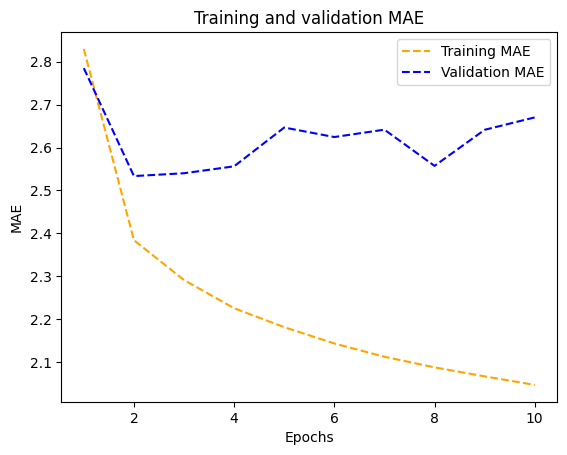

In [ ]:
#Plotting the results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="orange", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

*1D convolutional model*

In [ ]:
#Training and evaluating the model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)



Epoch 1/10
819/819 [==============================] - 16s 16ms/step - loss: 22.4180 - mae: 3.7222 - val_loss: 16.0974 - val_mae: 3.1396
Epoch 2/10
819/819 [==============================] - 13s 15ms/step - loss: 14.8851 - mae: 3.0577 - val_loss: 16.9098 - val_mae: 3.2910
Epoch 3/10
819/819 [==============================] - 13s 15ms/step - loss: 13.4367 - mae: 2.9003 - val_loss: 16.1517 - val_mae: 3.1953
Epoch 4/10
819/819 [==============================] - 13s 15ms/step - loss: 12.6465 - mae: 2.8119 - val_loss: 15.0352 - val_mae: 3.0702
Epoch 5/10
819/819 [==============================] - 13s 15ms/step - loss: 12.1336 - mae: 2.7513 - val_loss: 13.6647 - val_mae: 2.8959
Epoch 6/10
819/819 [==============================] - 13s 15ms/step - loss: 11.6370 - mae: 2.6895 - val_loss: 14.6909 - val_mae: 3.0314
Epoch 7/10
819/819 [==============================] - 13s 15ms/step - loss: 11.2140 - mae: 2.6386 - val_loss: 14.3231 - val_mae: 2.9643
Epoch 8/10
819/819 [============================

In [ ]:
#Evaluating test model
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}", "Degree celsius")

405/405 [==============================] - 4s 10ms/step - loss: 15.6281 - mae: 3.1020
Test MAE: 3.10 Degree celsius


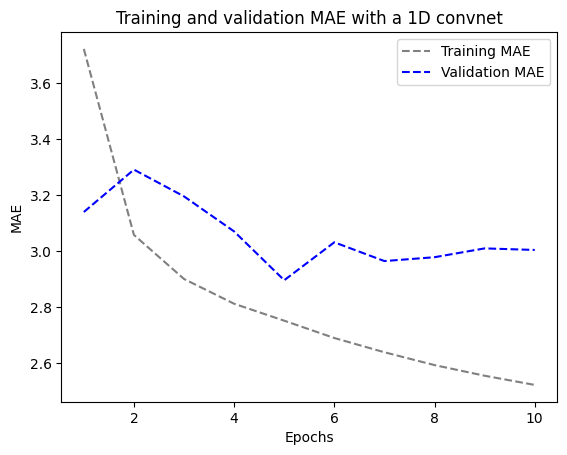

In [ ]:
#Plotting the results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE with a 1D convnet")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

It seems that the convolutional data performed poor compared to common sense or dense model. This could be because of the assumption of translation invariance that does not hold well for weather data.

The order of the data is crucial. Recent past data is significantly more informative for predicting the temperature of the following day compared to data from several days ago. Unfortunately, a 1D convolutional neural network is unable to effectively capture this critical temporal order.

**A Simple RNN**

1. An RNN layer can process sequences of any length

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)



Epoch 1/10
819/819 [==============================] - 50s 59ms/step - loss: 138.9093 - mae: 9.6962 - val_loss: 144.0497 - val_mae: 9.9063
Epoch 2/10
819/819 [==============================] - 49s 59ms/step - loss: 136.4740 - mae: 9.5691 - val_loss: 143.8037 - val_mae: 9.8827
Epoch 3/10
819/819 [==============================] - 48s 59ms/step - loss: 136.3876 - mae: 9.5629 - val_loss: 143.6938 - val_mae: 9.8727
Epoch 4/10
819/819 [==============================] - 48s 59ms/step - loss: 136.3154 - mae: 9.5550 - val_loss: 143.6022 - val_mae: 9.8595
Epoch 5/10
819/819 [==============================] - 48s 59ms/step - loss: 136.2047 - mae: 9.5420 - val_loss: 143.5873 - val_mae: 9.8556
Epoch 6/10
819/819 [==============================] - 48s 59ms/step - loss: 136.1799 - mae: 9.5392 - val_loss: 143.5921 - val_mae: 9.8574
Epoch 7/10
819/819 [==============================] - 49s 60ms/step - loss: 136.2354 - mae: 9.5453 - val_loss: 143.5493 - val_mae: 9.8502
Epoch 8/10
819/819 [==============

In [ ]:
#Evaluating the model

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}", "Degree celsius")

405/405 [==============================] - 7s 16ms/step - loss: 151.2708 - mae: 9.9170
Test MAE: 9.92 Degree celsius


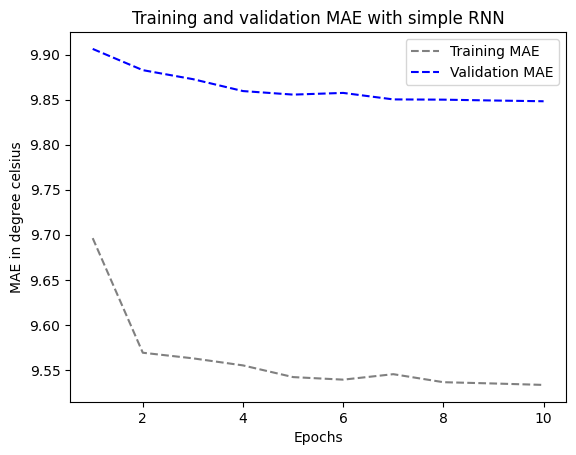

In [ ]:
#Plotting the results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE with simple RNN")
plt.xlabel("Epochs")
plt.ylabel("MAE in degree celsius")
plt.legend()
plt.show()

2. Stacking RNN Layers

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 200s 241ms/step - loss: 136.9256 - mae: 9.5670 - val_loss: 143.4248 - val_mae: 9.8382
Epoch 2/10
819/819 [==============================] - 195s 238ms/step - loss: 135.9497 - mae: 9.5113 - val_loss: 143.4205 - val_mae: 9.8377
Epoch 3/10
819/819 [==============================] - 195s 238ms/step - loss: 135.9006 - mae: 9.5060 - val_loss: 143.3855 - val_mae: 9.8330
Epoch 4/10
819/819 [==============================] - 197s 240ms/step - loss: 135.8700 - mae: 9.5006 - val_loss: 143.4145 - val_mae: 9.8369
Epoch 5/10
819/819 [==============================] - 195s 238ms/step - loss: 135.8373 - mae: 9.4958 - val_loss: 143.4308 - val_mae: 9.8427
Epoch 6/10
819/819 [==============================] - 196s 239ms/step - loss: 135.8184 - mae: 9.4926 - val_loss: 143.4358 - val_mae: 9.8432
Epoch 7/10
819/819 [==============================] - 197s 240ms/step - loss: 135.8090 - mae: 9.4912 - val_loss: 143.4318 - val_mae: 9.8400
Epoch 8/10
819/819 [

In [ ]:
#Evaluating the model

testmodel_stack = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {testmodel_stack.evaluate(test_dataset)[1]:.2f}", "Degree celsius")

405/405 [==============================] - 14s 34ms/step - loss: 151.0719 - mae: 9.8979
Test MAE: 9.90 Degree celsius


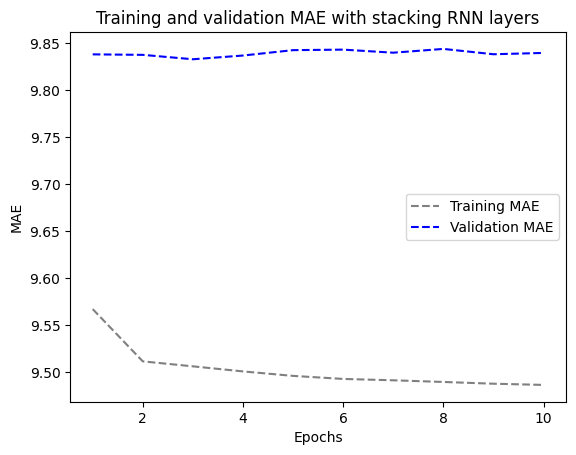

In [ ]:
#Plotting the results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE with stacking RNN layers")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

AS a part of Kera’s, we must create LSTM and GRU RNNs

**GRU (Gated Recurrent Unit)**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 16s 17ms/step - loss: 36.6809 - mae: 4.3921 - val_loss: 11.8734 - val_mae: 2.6083
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 10.3725 - mae: 2.5043 - val_loss: 9.4425 - val_mae: 2.3652
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 9.4834 - mae: 2.4003 - val_loss: 9.8329 - val_mae: 2.3858
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 9.1599 - mae: 2.3600 - val_loss: 10.7770 - val_mae: 2.4565
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 8.9433 - mae: 2.3345 - val_loss: 10.6503 - val_mae: 2.4441
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 8.7532 - mae: 2.3111 - val_loss: 11.0934 - val_mae: 2.4768
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 8.5746 - mae: 2.2897 - val_loss: 10.5635 - val_mae: 2.4486
Epoch 8/10
819/819 [==============================] - 1

In [ ]:
#Evaluating with test data
model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}", "Degree celsius")

405/405 [==============================] - 5s 11ms/step - loss: 10.3916 - mae: 2.5272
Test MAE: 2.53 Degree celsius


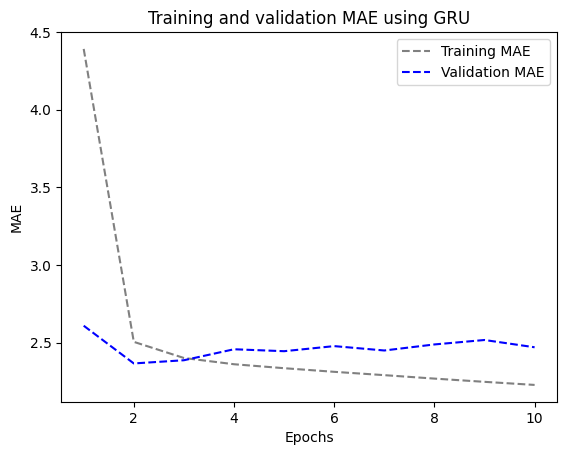

In [ ]:
#Plotting the results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE using GRU")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Long Short term memory model (LSTM)**

1. simple LSTM

In [ ]:
#A simple LSTM based model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 15s 17ms/step - loss: 35.9629 - mae: 4.3548 - val_loss: 11.5444 - val_mae: 2.5985
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 10.6571 - mae: 2.5451 - val_loss: 9.7524 - val_mae: 2.4290
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 9.6350 - mae: 2.4174 - val_loss: 9.9175 - val_mae: 2.4334
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 9.1883 - mae: 2.3574 - val_loss: 9.6762 - val_mae: 2.4029
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 8.8438 - mae: 2.3150 - val_loss: 10.5606 - val_mae: 2.4800
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 8.5980 - mae: 2.2845 - val_loss: 10.2361 - val_mae: 2.4575
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 8.4671 - mae: 2.2661 - val_loss: 10.2229 - val_mae: 2.4582
Epoch 8/10
819/819 [==============================] - 13

In [ ]:
#Evaluating with test data
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}", "Degree celsius")

405/405 [==============================] - 5s 10ms/step - loss: 10.3570 - mae: 2.5273
Test MAE: 2.53 Degree celsius


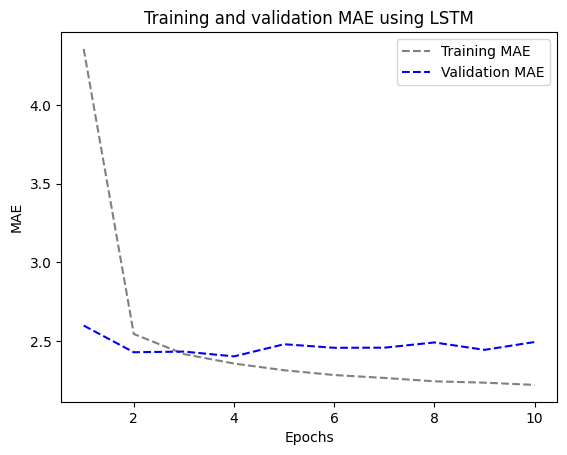

In [ ]:
#Plotting the results
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE using LSTM")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

2. LSTM - Dropout Regularization

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)



Epoch 1/10
819/819 [==============================] - 205s 246ms/step - loss: 47.5751 - mae: 5.1382 - val_loss: 13.4841 - val_mae: 2.7767
Epoch 2/10
819/819 [==============================] - 201s 245ms/step - loss: 20.2048 - mae: 3.4503 - val_loss: 9.9690 - val_mae: 2.4560
Epoch 3/10
819/819 [==============================] - 201s 246ms/step - loss: 18.2630 - mae: 3.2874 - val_loss: 9.5094 - val_mae: 2.4046
Epoch 4/10
819/819 [==============================] - 200s 244ms/step - loss: 17.3562 - mae: 3.2073 - val_loss: 9.2720 - val_mae: 2.3752
Epoch 5/10
819/819 [==============================] - 200s 244ms/step - loss: 16.8531 - mae: 3.1587 - val_loss: 9.1835 - val_mae: 2.3637
Epoch 6/10
819/819 [==============================] - 202s 246ms/step - loss: 16.3048 - mae: 3.1089 - val_loss: 9.1034 - val_mae: 2.3535
Epoch 7/10
819/819 [==============================] - 202s 247ms/step - loss: 15.9024 - mae: 3.0730 - val_loss: 9.2356 - val_mae: 2.3686
Epoch 8/10
819/819 [====================

In [ ]:
#Evaluating the test data
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}", "degree celsius")

405/405 [==============================] - 18s 42ms/step - loss: 10.1136 - mae: 2.4860
Test MAE: 2.49 degree celsius


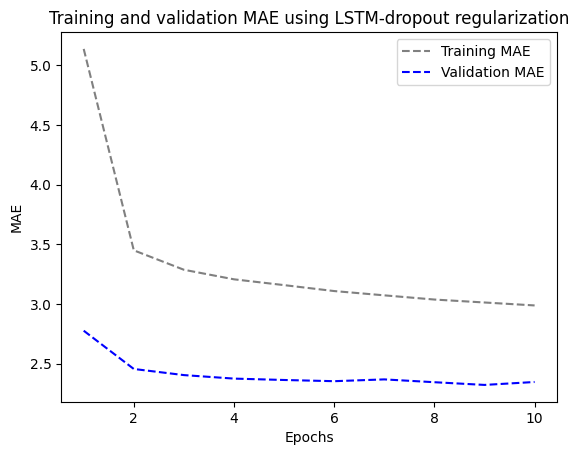

In [ ]:
#Plotting the results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE using LSTM-dropout regularization")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM - Stacked setup with 16 units

In [ ]:
#Training and evaluating the model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 20s 21ms/step - loss: 42.8725 - mae: 4.7707 - val_loss: 13.0787 - val_mae: 2.7162
Epoch 2/10
819/819 [==============================] - 17s 20ms/step - loss: 10.5350 - mae: 2.5089 - val_loss: 10.2590 - val_mae: 2.4745
Epoch 3/10
819/819 [==============================] - 17s 20ms/step - loss: 9.0336 - mae: 2.3380 - val_loss: 10.3043 - val_mae: 2.4881
Epoch 4/10
819/819 [==============================] - 16s 20ms/step - loss: 8.4223 - mae: 2.2575 - val_loss: 10.0794 - val_mae: 2.4691
Epoch 5/10
819/819 [==============================] - 16s 20ms/step - loss: 7.9343 - mae: 2.1917 - val_loss: 10.3234 - val_mae: 2.5007
Epoch 6/10
819/819 [==============================] - 17s 20ms/step - loss: 7.4162 - mae: 2.1200 - val_loss: 10.5505 - val_mae: 2.5452
Epoch 7/10
819/819 [==============================] - 16s 20ms/step - loss: 7.0264 - mae: 2.0643 - val_loss: 11.0772 - val_mae: 2.5983
Epoch 8/10
819/819 [==============================] -

In [ ]:
#Evaluating the model with test data

model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}", "degree celsius")

405/405 [==============================] - 5s 10ms/step - loss: 10.8831 - mae: 2.5806
Test MAE: 2.58 degree celsius


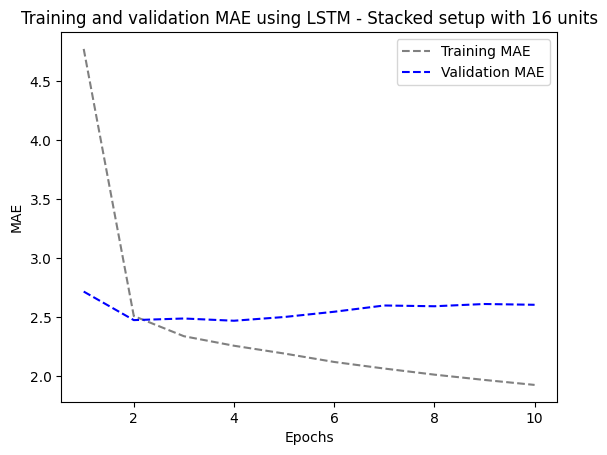

In [ ]:
#Plotting the results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE using LSTM - Stacked setup with 16 units")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM - Stacked setup with 32 units

In [ ]:
#training and evaluating the model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 20s 20ms/step - loss: 19.0230 - mae: 3.1560 - val_loss: 10.2382 - val_mae: 2.5125
Epoch 2/10
819/819 [==============================] - 16s 20ms/step - loss: 8.0323 - mae: 2.2075 - val_loss: 10.4486 - val_mae: 2.5063
Epoch 3/10
819/819 [==============================] - 16s 20ms/step - loss: 6.5748 - mae: 1.9920 - val_loss: 10.9553 - val_mae: 2.5865
Epoch 4/10
819/819 [==============================] - 16s 20ms/step - loss: 5.4372 - mae: 1.8104 - val_loss: 12.4728 - val_mae: 2.7577
Epoch 5/10
819/819 [==============================] - 16s 20ms/step - loss: 4.5802 - mae: 1.6571 - val_loss: 12.4884 - val_mae: 2.7911
Epoch 6/10
819/819 [==============================] - 17s 21ms/step - loss: 3.9328 - mae: 1.5358 - val_loss: 12.5633 - val_mae: 2.7654
Epoch 7/10
819/819 [==============================] - 17s 20ms/step - loss: 3.4883 - mae: 1.4461 - val_loss: 12.7326 - val_mae: 2.7792
Epoch 8/10
819/819 [==============================] - 

In [ ]:
#Evaluating the model with test data
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}", "Degree celsius")

405/405 [==============================] - 6s 11ms/step - loss: 11.5081 - mae: 2.6477
Test MAE: 2.65 Degree celsius


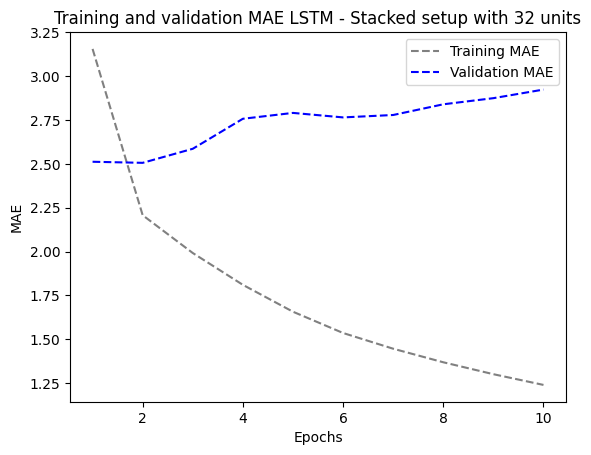

In [ ]:
#Plotting the results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE LSTM - Stacked setup with 32 units")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM - Stacked setup with 8 units

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 20s 21ms/step - loss: 61.8823 - mae: 5.9574 - val_loss: 29.7854 - val_mae: 4.0173
Epoch 2/10
819/819 [==============================] - 16s 20ms/step - loss: 18.6125 - mae: 3.2269 - val_loss: 12.0517 - val_mae: 2.6347
Epoch 3/10
819/819 [==============================] - 16s 20ms/step - loss: 11.1041 - mae: 2.5858 - val_loss: 9.6397 - val_mae: 2.3974
Epoch 4/10
819/819 [==============================] - 17s 20ms/step - loss: 10.0959 - mae: 2.4746 - val_loss: 9.5858 - val_mae: 2.3971
Epoch 5/10
819/819 [==============================] - 16s 20ms/step - loss: 9.7390 - mae: 2.4298 - val_loss: 9.4692 - val_mae: 2.3850
Epoch 6/10
819/819 [==============================] - 16s 20ms/step - loss: 9.4904 - mae: 2.3996 - val_loss: 9.5371 - val_mae: 2.3992
Epoch 7/10
819/819 [==============================] - 16s 20ms/step - loss: 9.3152 - mae: 2.3764 - val_loss: 9.3817 - val_mae: 2.3805
Epoch 8/10
819/819 [==============================] - 16

In [ ]:
#Evaluating the test model
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}", "degree celsius")

405/405 [==============================] - 6s 11ms/step - loss: 10.5027 - mae: 2.5309
Test MAE: 2.53 degree celsius


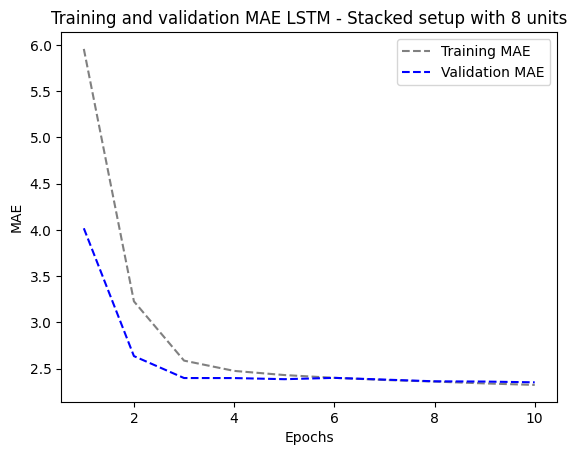

In [ ]:
#Plotting results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE LSTM - Stacked setup with 8 units")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

LSTM - dropout-regularized, stacked model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 441s 533ms/step - loss: 87.8062 - mae: 7.3093 - val_loss: 46.1406 - val_mae: 5.1207
Epoch 2/10
819/819 [==============================] - 437s 533ms/step - loss: 35.8886 - mae: 4.4590 - val_loss: 15.9892 - val_mae: 2.9598
Epoch 3/10
819/819 [==============================] - 433s 529ms/step - loss: 24.9292 - mae: 3.7768 - val_loss: 11.3879 - val_mae: 2.5790
Epoch 4/10
819/819 [==============================] - 432s 528ms/step - loss: 22.8063 - mae: 3.6242 - val_loss: 10.3249 - val_mae: 2.4806
Epoch 5/10
819/819 [==============================] - 432s 528ms/step - loss: 21.3834 - mae: 3.5134 - val_loss: 9.7796 - val_mae: 2.4211
Epoch 6/10
819/819 [==============================] - 433s 528ms/step - loss: 20.4021 - mae: 3.4389 - val_loss: 9.8266 - val_mae: 2.4336
Epoch 7/10
819/819 [==============================] - 431s 526ms/step - loss: 19.5055 - mae: 3.3641 - val_loss: 9.4060 - val_mae: 2.3816
Epoch 8/10
819/819 [=================

In [ ]:
#Evaluating the model with test dataset
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}", "degree celsius")

405/405 [==============================] - 30s 71ms/step - loss: 10.9716 - mae: 2.5603
Test MAE: 2.56 degree celsius


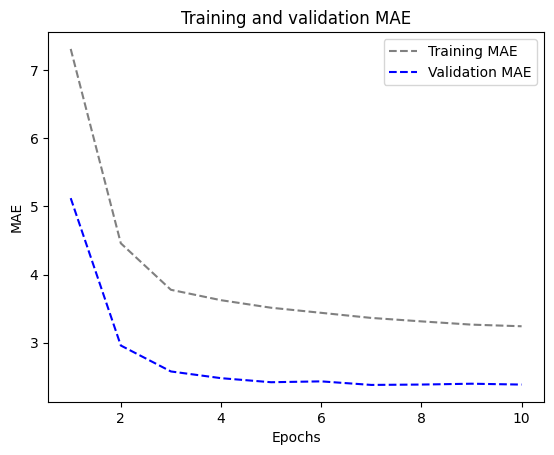

In [ ]:
#PLotting the results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


Bidirectional LSTM

In [ ]:
#training and evaluating the model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)



Epoch 1/10
819/819 [==============================] - 20s 20ms/step - loss: 26.5021 - mae: 3.6936 - val_loss: 10.3372 - val_mae: 2.5022
Epoch 2/10
819/819 [==============================] - 16s 20ms/step - loss: 9.4905 - mae: 2.4046 - val_loss: 9.6873 - val_mae: 2.4083
Epoch 3/10
819/819 [==============================] - 16s 20ms/step - loss: 8.5727 - mae: 2.2839 - val_loss: 9.6641 - val_mae: 2.4052
Epoch 4/10
819/819 [==============================] - 16s 19ms/step - loss: 8.0623 - mae: 2.2157 - val_loss: 9.7460 - val_mae: 2.4216
Epoch 5/10
819/819 [==============================] - 16s 20ms/step - loss: 7.6702 - mae: 2.1636 - val_loss: 9.8499 - val_mae: 2.4383
Epoch 6/10
819/819 [==============================] - 16s 19ms/step - loss: 7.3209 - mae: 2.1152 - val_loss: 10.4480 - val_mae: 2.5043
Epoch 7/10
819/819 [==============================] - 16s 19ms/step - loss: 7.0376 - mae: 2.0744 - val_loss: 10.8384 - val_mae: 2.5487
Epoch 8/10
819/819 [==============================] - 16s 

In [ ]:
#Evaluating the model with test dataset
model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}", "degree celsius")

405/405 [==============================] - 6s 11ms/step - loss: 10.9025 - mae: 2.6069
Test MAE: 2.61 degree celsius


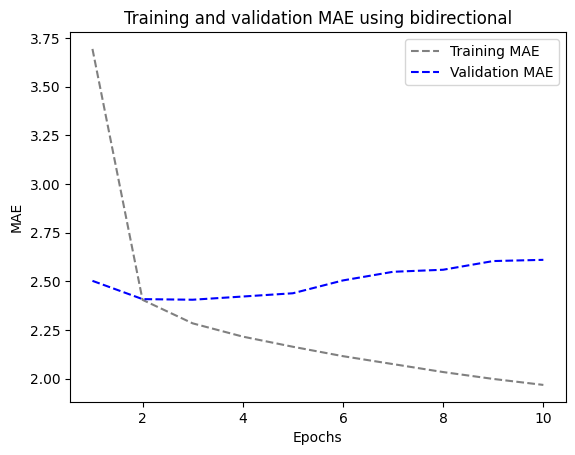

In [ ]:
#Plotting the result

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE using bidirectional")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

1D Convnets and LSTM togther

In [ ]:
#Training and evaluating the test dataset

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)



Epoch 1/10
819/819 [==============================] - 16s 17ms/step - loss: 51.8636 - mae: 5.3887 - val_loss: 27.4889 - val_mae: 4.0424
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 17.9172 - mae: 3.2648 - val_loss: 20.6584 - val_mae: 3.6061
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 14.6230 - mae: 2.9700 - val_loss: 22.3530 - val_mae: 3.7984
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 12.9590 - mae: 2.7925 - val_loss: 21.4044 - val_mae: 3.6814
Epoch 5/10
819/819 [==============================] - 13s 16ms/step - loss: 11.8404 - mae: 2.6604 - val_loss: 23.4038 - val_mae: 3.8346
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 10.9151 - mae: 2.5521 - val_loss: 23.6502 - val_mae: 3.9018
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 10.2585 - mae: 2.4711 - val_loss: 23.3705 - val_mae: 3.8338
Epoch 8/10
819/819 [============================

In [ ]:
#Evaluating the model with test dataset
model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}", "degree celsius")

405/405 [==============================] - 5s 10ms/step - loss: 23.2048 - mae: 3.8166
Test MAE: 3.82 degree celsius


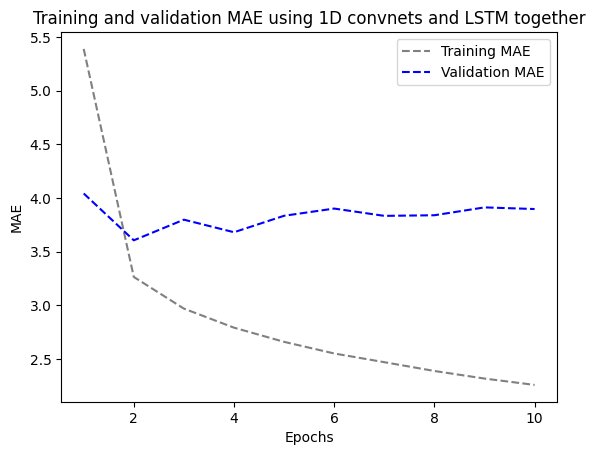

In [ ]:
#plotting the results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE using 1D convnets and LSTM together")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


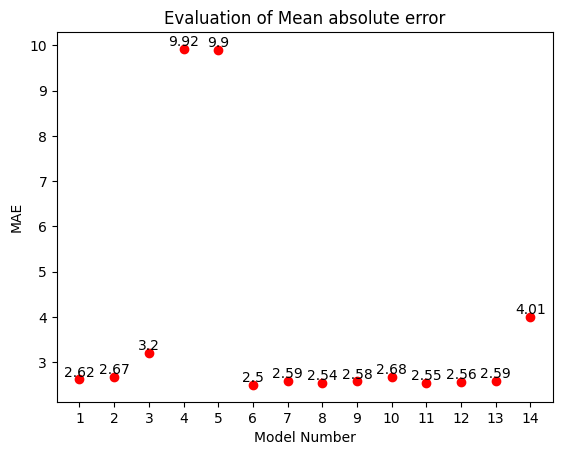

In [ ]:
#MAE Evaluation

Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.67,3.2,9.92,9.9,2.5,2.59,2.54,2.58,2.68,2.55,2.56,2.59,4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("Evaluation of Mean absolute error")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()